<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#注意" data-toc-modified-id="注意-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>注意</a></span></li><li><span><a href="#加载数据和模型" data-toc-modified-id="加载数据和模型-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>加载数据和模型</a></span></li><li><span><a href="#检测椭圆" data-toc-modified-id="检测椭圆-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>检测椭圆</a></span></li><li><span><a href="#保存检测结果" data-toc-modified-id="保存检测结果-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>保存检测结果</a></span></li><li><span><a href="#输出结果" data-toc-modified-id="输出结果-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>输出结果</a></span></li></ul></div>

# 注意

- 采用的是V2版的椭圆检测

In [1]:
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/05_experiments')
from experiment import *
from cc_ellipse_v2 import *
import os


In [2]:
dataset = '02_prasad'
raw_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{dataset}/01_raw/'
result_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{dataset}/05_ellipse_result/proposed/'
label_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{dataset}/04_ellipse_label/'

In [3]:
import os 
fnames = os.listdir(raw_path)
fnames = [n[:-4] for n in fnames if n[-3:]=='jpg']
fnames.sort()
print(fnames[:10])

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


# 加载数据和模型

In [4]:
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/01_data')
from cc_process_image import *
import imageio

raws = get_all_images(f'{raw_path}',fnames,'jpg',itype='gray')

print(len(raws))

/home/liucc/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/liucc/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


198


In [5]:
gts = []

for name in fnames:
    lname = label_path+name+'.txt'
    
    with open(lname,'r') as f:
        txt = f.read()
        
        ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n')]
        
        gts.append(ells_t)
        

print(len(gts))

198


In [6]:
sys.path.append('/home/liucc/Workspace/02_Ellipse/02_algorithm/01_cnn')
from cnn_model import *

model_path = r'/home/liucc/Workspace/02_Ellipse/06_model/'
model_name = r'ellipse_general'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = RestoreNet(channel=1).to(device)

model.load_state_dict(torch.load(f'{model_path}{model_name}.mdl')['state_dict'])

# 检测椭圆

In [7]:
import time

def one_task(glob):
    start = time.time()

    prs = []
    
    for im in raws:
        im = preprocess_image(im)
        imo = predict(model,im, device)
        imo = postprocess_image(imo,thr=0.3)
        ells = detect_ellipses_im(imo,glob)
        
        prs.append(ells)

    end = time.time()
    
    cost = (end-start)/len(raws)
    
    precision,recall,F1,_,_ = cal_metrics(prs,gts,threshold=0.8)
    
    
    return [precision,recall,F1,cost,prs]

In [8]:
#全局参数
GLOB = {
    'MAX_FIT_DIS':2,
    'MAX_DIS':130,
    'MAX_ANGLE':50,
    'MIN_LEN' : 40,
    'MIN_COVER_ANGLE' : 110,
    'MIN_COVER_RHO1' : 0.4,
    'MIN_COVER_RHO2' : 0.34,
}
precision,recall,F1,costT,prs = one_task(GLOB)

In [9]:
print('Precision:%.4f' % precision)
print('Recall:   %.4f' % recall)
print('F1 Score: %.4f' % F1)
print('Avg Time: %.0f' % (costT*1000))

Precision:0.7760
Recall:   0.3761
F1 Score: 0.5066
Avg Time: 214


# 保存检测结果

In [10]:

for pr,name in zip(prs,fnames):
    oname = result_path+name+'.txt'
    
    with open(oname,'w') as f:
        f.write("\n".join([" ".join(map(str,ell)) for ell in pr])) 
    


# 输出结果

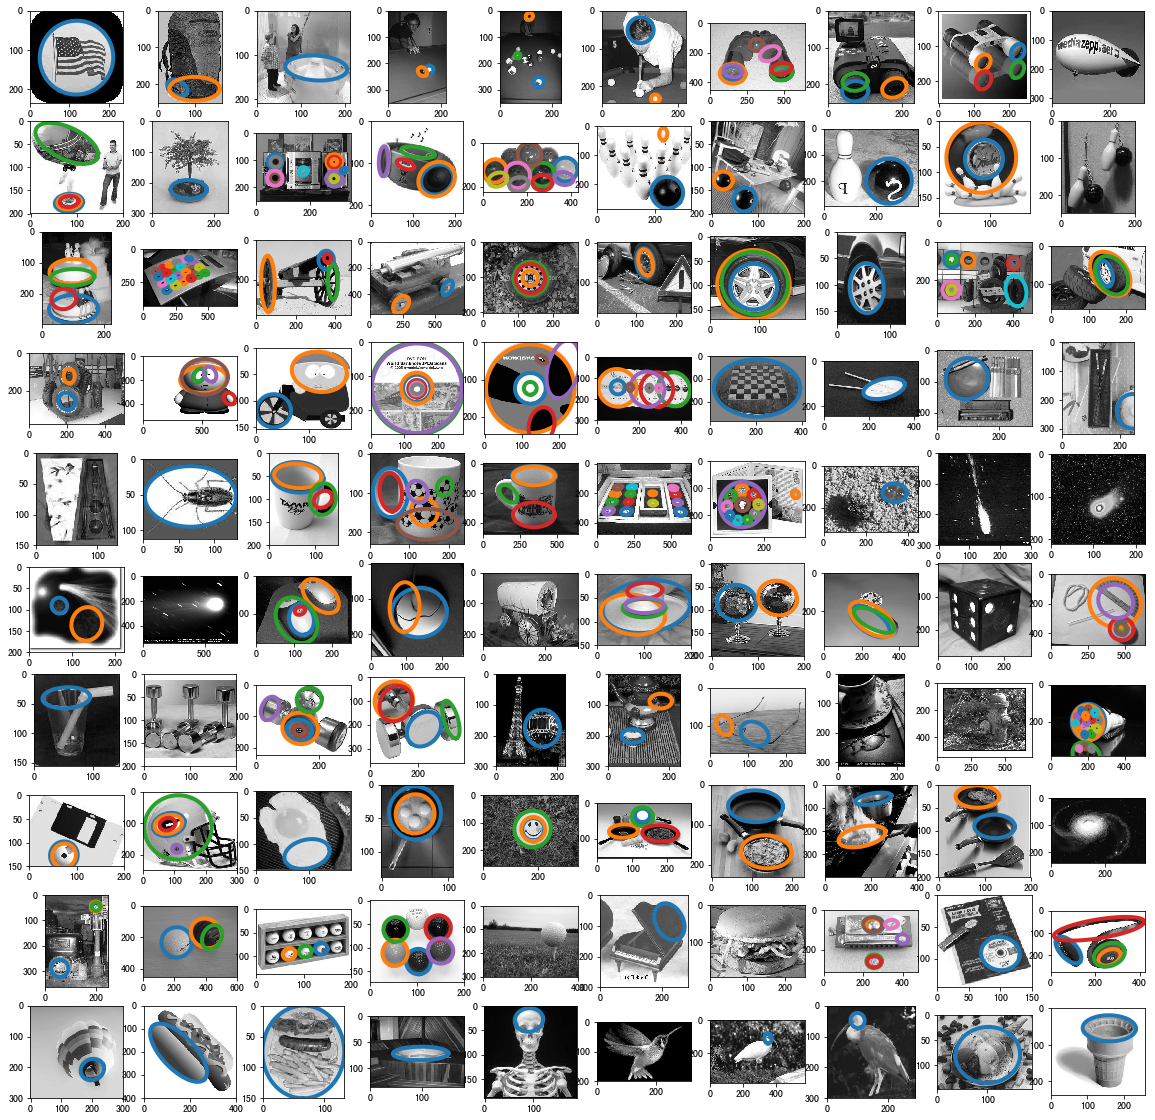

In [11]:
num = 100
_,axes = plt.subplots(nrows=10,ncols=10,figsize=(20,20)) 

axes = axes.reshape(-1)

for ax,ells,im in zip(axes,prs[:num],raws[:num]):
    for ell in ells:
        exy = draw_ellipse(*ell)
        ax.plot(exy[0,:],exy[1,:],linewidth='4')
        
    ax.imshow(im,cmap='gray')

plt.show()